In [32]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [33]:
train = pd.read_csv('Desktop/jupyter/tabular-playground-series-mar-2021/train.csv')
test = pd.read_csv('Desktop/jupyter/tabular-playground-series-mar-2021/test.csv')
sample_submission = pd.read_csv('Desktop/jupyter/tabular-playground-series-mar-2021/sample_submission.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

# label encoding
for col in train.columns[:19].to_list():
    train[col].replace(train[col].unique(), range(train[col].nunique()), inplace=True)
    test[col].replace(test[col].unique(), range(test[col].nunique()), inplace=True)

In [34]:
N = len(train)
X_train = train.drop('target', axis=1)
y_train = train['target']
X_test = test

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [36]:
N, D = X_train.shape

In [37]:
# Scale the data
# you'll learn why scaling is needed in a later course
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [39]:
X_train = np.array(X_train.astype(np.float32))
y_train = np.array(y_train.astype(np.float32))
X_test = np.array(X_test.astype(np.float32))
X_val = np.array(X_val.astype(np.float32))
y_val = np.array(y_val.astype(np.float32))

In [40]:
# Convert data into torch tensors
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy((y_train).reshape(-1, 1))
X_test = torch.from_numpy(X_test)
X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy((y_val).reshape(-1, 1))

In [133]:
# Now all the fun PyTorch stuff
# Build the model
model = nn.Sequential(
    nn.BatchNorm1d(D),
    nn.Linear(D, int(D*0.7)),
    nn.ReLU(),
    nn.BatchNorm1d(int(D*0.7)),
    nn.Linear(int(D*0.7), int(D*0.5)),
    nn.ReLU(),
    nn.BatchNorm1d(int(D*0.5)),
    nn.Linear(int(D*0.5), int(D*0.3)),
    nn.ReLU(),
    nn.BatchNorm1d(int(D*0.3)),
    nn.Linear(int(D*0.3), int(D*0.1)),
    nn.ReLU(),
    nn.BatchNorm1d(int(D*0.1)),
    nn.Linear(int(D*0.1), 1),
    nn.Sigmoid()
)

In [134]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
n_epochs = 1000

# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Get test loss
    outputs_test = model(X_val)
    loss_test = criterion(outputs_test, y_val)

    # Save losses
    train_losses[it] = loss.item()
    test_losses[it] = loss_test.item()

    if (it + 1) % 50 == 0:
        print(f'Epoch {it+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss_test.item():.4f}')

Epoch 50/1000, Train Loss: 0.5048, Test Loss: 0.5034
Epoch 100/1000, Train Loss: 0.4611, Test Loss: 0.4600
Epoch 150/1000, Train Loss: 0.4340, Test Loss: 0.4333
Epoch 200/1000, Train Loss: 0.4182, Test Loss: 0.4187
Epoch 250/1000, Train Loss: 0.4080, Test Loss: 0.4086
Epoch 300/1000, Train Loss: 0.3998, Test Loss: 0.4008
Epoch 350/1000, Train Loss: 0.3949, Test Loss: 0.3951
Epoch 400/1000, Train Loss: 0.3907, Test Loss: 0.3915
Epoch 450/1000, Train Loss: 0.3887, Test Loss: 0.3894
Epoch 500/1000, Train Loss: 0.3867, Test Loss: 0.3883
Epoch 550/1000, Train Loss: 0.3853, Test Loss: 0.3866
Epoch 600/1000, Train Loss: 0.3841, Test Loss: 0.3858
Epoch 650/1000, Train Loss: 0.3830, Test Loss: 0.3834
Epoch 700/1000, Train Loss: 0.3823, Test Loss: 0.3839
Epoch 750/1000, Train Loss: 0.3817, Test Loss: 0.3834
Epoch 800/1000, Train Loss: 0.3810, Test Loss: 0.3830
Epoch 850/1000, Train Loss: 0.3804, Test Loss: 0.3834
Epoch 900/1000, Train Loss: 0.3809, Test Loss: 0.3829
Epoch 950/1000, Train Loss: 0

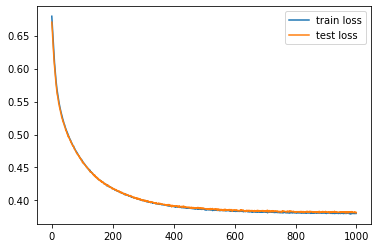

In [135]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [136]:
# Get accuracy
with torch.no_grad():
    p_train = model(X_train)
    p_train = np.round(p_train.numpy())
    train_acc = np.mean(y_train.numpy() == p_train)

    p_val = model(X_val)
    p_val = np.round(p_val.numpy())
    test_acc = np.mean(y_val.numpy() == p_val)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.8354, Test acc: 0.8356


In [ ]:
# Train acc: 0.8435, Test acc: 0.8422
# .7 .5 .3 .1 Train acc: 0.8443, Test acc: 0.8417
# .8 .6 .4 .2 Train acc: 0.8455, Test acc: 0.8401 over fitting 